The goal of this notebook is to look at the sparcity of the models trained and then try to analyze those features that appear important and see if they are shared in datasets. <br> Do these features map to statistically significant features (whats ratio of features turned on vs the number of significant features)? <br> Do these features map to meaningful compounds in the disease? <br>Are the more sparce models better in terms of AUC?

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from collections import OrderedDict
import glob
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
pd.set_option('display.max_rows', 500) 
pd.set_option('display.max_columns', 100)

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.utils.multiclass import type_of_target # used to check the Y labels are appropriate for classification
from sklearn.metrics import roc_curve
from sklearn import metrics
from sklearn.utils import shuffle
from scipy import interp

In [2]:
def convert_nan_to_val(data, value=0):
    data[pd.isnull(data)] = value
    return data

def extract_random_subset(X, y, percent):
    num_to_keep = int(X.shape[0]*percent)
    idx = np.random.randint(X.shape[0], size=num_to_keep)
    return X[idx,:], y[idx,:].ravel()

def l1_log_reg(X,y,ds):
    X,y = shuffle(X,y)
    # intercept scaling of 1 seems to help with the 0.5 AUC, think it was a convergence issues? 
    clf = LogisticRegressionCV(scoring='roc_auc', penalty='l1', solver='liblinear', tol=1e-4, intercept_scaling=1, max_iter=500)
    cv = StratifiedKFold(n_splits=3, shuffle=True)
    aucs = []
    if ds['study'] == 'MTBLS423':
        y[y==6] = 1
    for train, test in cv.split(X,y):
        x_train, y_train = X[train], y[train]
        x_test,y_test = X[test], y[test]
        scaler = StandardScaler()
        x_train = scaler.fit_transform(x_train)
        x_test = scaler.transform(x_test)
        clf.fit(x_train, y_train)
        if ds['num_labels'] != 2:
            aucs.append(clf.score(x_test, y_test))
        else:
            y_pred = clf.predict_proba(x_test)
            fpr, tpr, _ = roc_curve(y_test, y_pred[:,1])
            auc_value = metrics.auc(fpr, tpr)
            aucs.append(auc_value)            
    auc = np.asarray(aucs)
    # found sometimes that something will just go wrong in fitting and it will shut down all features and give a 0.5 model
    # also sometimes the 1.0 models are fit wrong...
    if auc.mean() == 1.0 or auc.mean() == 0.5:
        X,y = shuffle(X,y)
        clf = LogisticRegressionCV(penalty='l1', scoring='roc_auc', solver='liblinear', tol=1e-4, intercept_scaling=1, max_iter=500)
        cv = StratifiedKFold(n_splits=3, shuffle=True)
        aucs = []
        for train, test in cv.split(X,y):
            x_train, y_train = X[train], y[train]
            x_test,y_test = X[test], y[test]
            scaler = StandardScaler()
            x_train = scaler.fit_transform(x_train)
            x_test = scaler.transform(x_test)
            clf.fit(x_train, y_train)
            if ds['num_labels'] != 2:
                aucs.append(clf.score(x_test, y_test))
            else:
                y_pred = clf.predict_proba(x_test)
                fpr, tpr, _ = roc_curve(y_test, y_pred[:,1])
                auc_value = metrics.auc(fpr, tpr)
                aucs.append(auc_value)  
    return auc.mean(), auc.std(), clf

In [3]:
from scipy.stats import mannwhitneyu
from scipy.stats import kruskal
from statsmodels.stats.multitest import multipletests

def convert_nan_to_val(data, value=0):
    data[pd.isnull(data)] = value
    return data

def fdr_corrected_p(dataset, fill_nan=False, zero_to_val=0, log=False):
    X = dataset['features'].values.copy()
    # tuning the data with nan filling to 0, changing 0s to a diff number and or applying log transform
    X[np.isinf(X)] = 0
    if fill_nan:
        X = convert_nan_to_val(X, value=0)
    if zero_to_val != 0:
        X[X==0] = zero_to_val
    if log:
        X = np.log2(X)
    
    y = dataset['labels'].values.ravel()
    y = np.asarray([int(i) for i in y])
    p = np.zeros(X.shape[1]) + np.nan
    for i in range(X.shape[1]):
        try:
            assert len(y) > 0
            X_0 = X[y==0,i]
            X_0 = X_0[~np.isnan(X_0)]
            X_1 = X[y!=0,i]
            X_1 = X_1[~np.isnan(X_1)]
#             plt.hist(X_0)
#             plt.hist(X_1)
#             plt.show()
            _, p[i] = mannwhitneyu(X_0, X_1, alternative='two-sided')
#             print(p[i])
        except:
            pass
    try:
        _, p[~np.isnan(p)], _, _ = multipletests(p[~np.isnan(p)], alpha=0.05, method='fdr_bh')
    except:
        pass
    dataset['pvalues'] = p
    dataset['significant'] = (dataset['pvalues'] < 0.05).sum() if (~np.isnan(p)).any() else np.nan

In [4]:
#### Use this if NOT doing a fresh modeling fitting analysis
pickle_file = './YES_bn_ds_models_and_sigfeat_NO_log_NO_standscal_NO_multi_mapped_labels.pkl'
### The non-batch corrected pickle for the dataset
# pickle_file = './NO_bn_dataset_models_and_sigfeat_YES_log.pkl'
datasets = pickle.load(open(pickle_file, 'rb'))

In [4]:
datasets = OrderedDict()
for fn in sorted(glob.glob('./pickles/*.pkl')):
    data = pd.read_pickle(open(fn,'rb'))
    datasets[data[0]['study']] = data

Get the significant peaks and the features turned on as well as the corresponding mz-rt features (if available). <br>
Important additions to the ds object: <br>
ds['coefs'] = ALL coeficients of the model <br>
ds['pvalues] = all the pvalues of the model  <br>
ds['mz_rt_coef'] = mz-rt features corresponding to the NON 0 features <br>
ds['mz_rt_sig'] = mz-rt features corresponding to the p<0.05 features <br>

In [5]:
for k, v in datasets.items(): 
#     if k != 'MTBLS92':
#         continue
    for ds in v:        
        if k in ['MTBLS148','MTBLS200', 'MTBLS20', 'ST000397', 'MTBLS264', 'snyder']: # need to pass since really no labels here
            continue
        ds['labels'] = ds['labels']*1
        vals = ds['labels'].values
        try:
            vals = [item for sublist in vals for item in sublist]
        except:
            pass
        labels = set(vals)
        ds['num_labels'] = len(labels)
        if ds['num_labels'] != 2:
            continue
        if ds['data_set'] == 'IPO_aligned_MTBLS92':
            f = [fi for fi in list(ds['features'].index) if '163' in fi]
            ds['features'] = ds['features'].loc[f]
            ds['labels'] = ds['labels'].loc[f]
        if ds['study'] == 'MTBLS92' and ds['data_set'] == 'Author_data':
            f = [fi for fi in list(ds['features'].index) if 'A' in fi]
            ds['features'] = ds['features'].loc[f]
            ds['labels'] = ds['labels'].loc[f] 
        
        X = ds['features'].values.copy()
        y = ds['labels'].values.copy().astype(int).ravel()
        X = convert_nan_to_val(X, value=0)
        X[np.isinf(X)] = 0
        # for log transform:
        if 'IPO' in ds['data_set'] or 'XCMS' in ds['data_set']:
            X[X==0] = 1
            X = np.log2(X)
        # train a model 
        auc_mean, auc_std, model = l1_log_reg(X,y, ds)
        coefs = np.squeeze(model.coef_)
        ds['coefs'] = coefs
        ds['auc'] = auc_mean
        fdr_corrected_p(ds, fill_nan=True, zero_to_val=1, log=True)
        replace = {'mass_to_charge':'mz', 'mzmed':'mz', 'Mass':'mz', 'm/z':'mz', 'Mass-to-Charge':'mz',
                   'retention_time':'rt', 'rtmed':'rt', 'Retention Time':'rt', 'RT':'rt'}
        ds['peaks'] = ds['peaks'].rename(replace)
        mz_rt_pairs = [['mz','rt'], ['Mass-to-Charge']]
        for pair in mz_rt_pairs:
            try:
                # get the mz-rt features that correspond to the coefs > 0 and pvalues <0.05
                mz_rt_coef = ds['peaks'][pair][ds['coefs']>0]
                mz_rt_sig = ds['peaks'][pair][ds['pvalues']<0.05]   
                ds['mz_rt_coef'] = mz_rt_coef
                ds['mz_rt_sig'] = mz_rt_sig
            except:
                continue

/home/ubuntu/data/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in log2
/home/ubuntu/data/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less
/home/ubuntu/data/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in less


Look at the overlap of features: <br>
Do the reprocessed datasets get the same mz-rt features as the author data? <br>
To code: inside on study, its just a list of datasets, need to map the reprocessed ones to the author data

In [5]:
# to map the reprocessed studies to the author data
# idea: want to compare two datasets, need to have both mz-rt feature tables at once, so look up in a given study the desired tuples

# manually mapping the same studies:
reprocessed_to_author = {'Feng':[(0,2), (0,3), (2,3), (1, 4), (1,5), (4,5)],
#                           'MTBLS105':[],
#                           'MTBLS146':[],
#                           'MTBLS148':[],
                          'MTBLS17':[(0,9),(1,10),(2,11),(3,6),(4,7),(5,8)],
#                           'MTBLS191':[],
                          'MTBLS19':[(0,12),(1,13),(2,14),(3,15),(4,8),(5,9),(6,10),(7,11)],
#                           'MTBLS200':[],
#                           'MTBLS20':[],
#                           'MTBLS218':[],
#                           'MTBLS253':[],
                          'MTBLS264':[(0,10), (1,6), (2,8), (3,11), (4,7), (5,9)],
                          'MTBLS266':[(0,2), (1,3)],
#                           'MTBLS279':[],
                          'MTBLS28':[(0,2), (1,3)],
                          'MTBLS315':[(0,4), (1,5), (2,6), (3,7), (0,8), (4,8), (2,9), (6,9)],
                          'MTBLS352':[(0,2)],
                          'MTBLS354':[(0,3), (1,2)],
#                           'MTBLS358':[],
#                           'MTBLS364':[],
                          'MTBLS404':[(0,1)],
#                           'MTBLS408':[],
                          'MTBLS423':[(0,1)],
#                           'MTBLS579':[],
                          'MTBLS665':[(0,2),(1,3)],
#                           'MTBLS72':[],
                          'MTBLS92':[(0,1)],
                          'ST000045':[(0,4), (1,5), (2,6), (3,7)],
                          'ST000046':[(0,6), (0,8), (6,8), (1,9), (1,10), (9,10), (2,7), (2,11), (7,11), (3,4), (3,5), (4,5)],
                          'ST000063':[(0,1), (0,2), (1,2)],
#                           'ST000284':[],
                          'ST000329':[(0,2), (1,3)],
#                           'ST000355':[],
#                           'ST000356':[],
                          'ST000381':[(0,3)],
#                           'ST000383':[],
                          'ST000385':[(0,4),(1,5),(2,6),(3,7)],
                          'ST000388':[(0,1)],
                          'ST000389':[(0,1)],
                          'ST000392':[(0,2),(1,3)],
                          'ST000396':[(0,1)],
                          'ST000397':[(0,1)],
                          'ST000421':[(8,1), (8,5), (5,1), (9,0), (9,4), (0,4), (10,3), (10,7), (3,7), (11,2), (11,6), (2,6)],
#                           'ST000450':[],
                          'ST000578':[(0,3), (1,2)],
#                           'ST000608':[],
                          'ST000726':[(0,2), (1,3)],
                          'ST000763':[(0,2), (1,3)],
                          'ST000865':[(0,1), (0,2), (1,2)],
#                           'ST000888':[],
#                           'ST000918':[],
                         }

In [12]:
round_num = 3

for k, v in datasets.items():
#     for ds in v:
#         try:
#             print(k, ds['num_labels'])
#         except:
#             print(k, 'no data')
    if k not in ['ST000421']:
        continue
    for pair in reprocessed_to_author[k]:
        mz_rt_coef_1 = datasets[k][pair[0]]['mz_rt_coef'].round(round_num)#.set_index('mz')
        mz_rt_sig_1 = datasets[k][pair[0]]['mz_rt_sig'].round(round_num)#.set_index('mz')
        mz_rt_coef_2 = datasets[k][pair[1]]['mz_rt_coef'].round(round_num)#.set_index('mz')
        mz_rt_sig_2 = datasets[k][pair[1]]['mz_rt_sig'].round(round_num)#.set_index('mz')
        
        sig_1_2 = mz_rt_sig_1.merge(mz_rt_sig_2, on='mz', how='left')
        coef_1_2 = mz_rt_coef_1.merge(mz_rt_coef_2, on='mz', how='left')
        print(sig_1_2)

          mz     rt_x  rt_y
0    163.060  150.489   NaN
1    198.971  117.286   NaN
2    199.037  150.985   NaN
3    199.975  119.266   NaN
4    200.042  150.988   NaN
5    206.071  151.482   NaN
6    207.067  151.482   NaN
7    207.079  121.742   NaN
8    208.070  151.478   NaN
9    208.064  120.504   NaN
10   209.045  123.230   NaN
11   209.051  118.783   NaN
12   209.066  150.490   NaN
13   217.443  156.685   NaN
14   227.033  151.482   NaN
15   242.048  151.478   NaN
16   242.957  121.739   NaN
17   242.962  116.790   NaN
18   243.045  151.482   NaN
19   243.964  121.744   NaN
20   244.047  151.482   NaN
21   253.052  123.723   NaN
22   261.078  150.986   NaN
23   262.084  150.988   NaN
24   262.986  150.983   NaN
25   267.045  151.481   NaN
26   276.079  154.450   NaN
27   276.931  165.357   NaN
28   296.083   72.453   NaN
29   302.014  151.485   NaN
30   303.010  151.482   NaN
31   304.012  151.485   NaN
32   305.009  151.972   NaN
33   305.038  119.269   NaN
34   306.011  151.97

Making Venn diagrams for all the data sets 

132 46 18 7


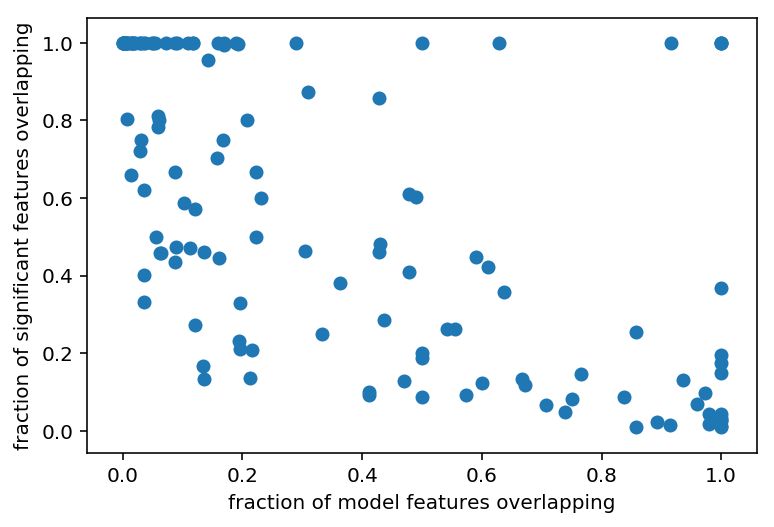

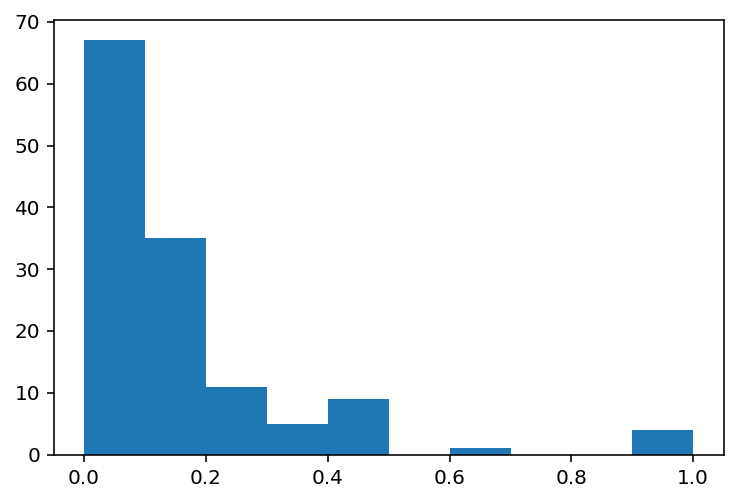

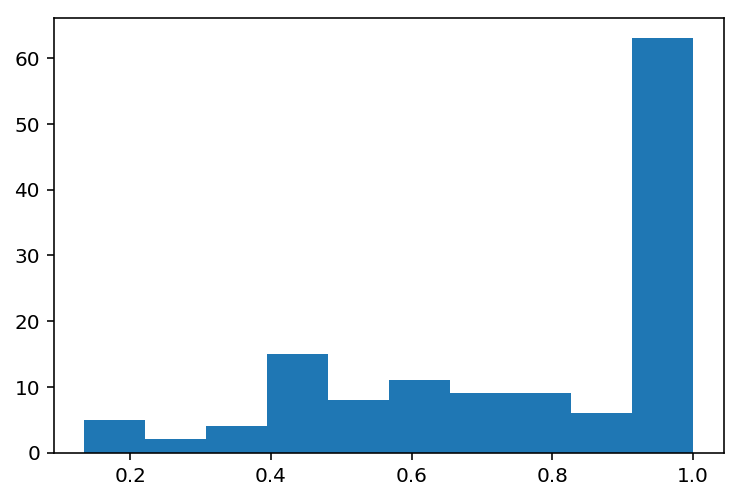

In [6]:
# NOTE IN THE PAST THIS WAS ONLY LOOKING AT POSITIVE L1-FEATURES---SHOULD ALSO CONSIDER NEGATIVE NON ZERO FEATURES
relative_model = []
relative_sigfeat = []
larger = []
lesser = []
auc_no_sigfeat = []
total = 0
most_sigfeat = 0
most_modelfeat = 0
lower_end = 0
for k, v in datasets.items():
#     if k != 'MTBLS92':
#         continue
    for ds in v:
        try:
            ps = np.asarray(ds['pvalues']) # get the p values for all features 
            p_lt_cutoff = ps[ps<0.05] # find the p values < cutoff
            
            ##### if loading pretrained models:
            coef = np.squeeze(ds['clf'].coef_)
            p_to_coef = coef[ps<0.05]
            coef_gt_cutoff = coef[coef!=0]
            ##### if not loading the pretrained models:
#             p_to_coef = ds['coefs'][ps<0.05] # find L1 model coefs where p < cut off
#             coef_gt_cutoff = ds['coefs'][ds['coefs']!=0] # find all non zero L1 model coefficients 

            p_to_coef = p_to_coef[p_to_coef!=0] # of the L1-features that happen to correspond to stat sig LCMS features
            #...which of these are non zero coefs (ie this is the overlap)
            
#             print('total features:', ps.shape, ds['coefs'].shape)
#             print(p_lt_cutoff.shape[0], coef_gt_cutoff.shape[0], p_to_coef.shape[0])

            overlap = p_to_coef.shape[0]
            if coef_gt_cutoff.shape[0] > 0 and p_lt_cutoff.shape[0] > 0:
                total += 1
#                 print(k, ds['data_set'])
#                 print(overlap/coef_gt_cutoff.shape[0],overlap/p_lt_cutoff.shape[0])
                
                model_coef_ratio = overlap/coef_gt_cutoff.shape[0]
                if model_coef_ratio > 0.95:
                    most_modelfeat += 1
                sigfeat_coef_ratio = overlap/p_lt_cutoff.shape[0]
                if sigfeat_coef_ratio > 0.95:
                    most_sigfeat += 1
                if model_coef_ratio < 0.3 and sigfeat_coef_ratio < 0.3:
                    lower_end += 1
                
                lesser.append(min(overlap/coef_gt_cutoff.shape[0], overlap/p_lt_cutoff.shape[0]))
                larger.append(max(overlap/coef_gt_cutoff.shape[0], overlap/p_lt_cutoff.shape[0]))
                relative_model.append(overlap/coef_gt_cutoff.shape[0])
                relative_sigfeat.append(overlap/p_lt_cutoff.shape[0])
            else:
                pass
 ##### plotting the venn diagrams           
#             venn2(subsets = (p_lt_cutoff.shape[0]-p_to_coef.shape[0], coef_gt_cutoff.shape[0]-p_to_coef.shape[0], p_to_coef.shape[0]), set_labels = ('Ps less than 0.05', 'non 0 coefficients'))
#             plt.text(1,0.3,'total number of features: %d' %(coef.shape[0]))
#             plt.text(1,0.2, 'total sig. p values: {}'.format(p_lt_cutoff.shape[0]))
#             plt.text(1,0.1, 'total non-zero feat: {}'.format(coef_gt_cutoff.shape[0]))
#             plt.title('%s - data set: %s     AUC: %.2f'%(k, ds['data_set'], ds['auc']))
# #             plt.show()
#             plt.savefig('./bn_venn_coef_sigfeat/'+k+'_'+ds['data_set'], bbox_inches = "tight")
#             plt.gcf().clear()
    #         ps[ps<0.05] = 0.05
    #         ps[ps>0.05] = 0
    #         plt.scatter([x for x in range(len(ds['pvalues']))], ps)
#             plt.show()

        except:
            pass

plt.scatter(relative_model, relative_sigfeat)
# print(relative_model, relative_sigfeat)
print(total, most_sigfeat, most_modelfeat, lower_end)
plt.xlabel('fraction of model features overlapping')
plt.ylabel('fraction of significant features overlapping')
plt.show()
plt.hist(lesser)
plt.show()
plt.hist(larger)
plt.show()